# Netflix Movie Recommendation System

## Business Problem
Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better. Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business. Credits: https://www.netflixprize.com/rules.html

## Problem Statement
Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)

## Sources
- https://www.netflixprize.com/rules.html
- https://www.kaggle.com/netflix-inc/netflix-prize-data
- Netflix blog: https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429 (very nice blog)
- surprise library: http://surpriselib.com/ (we use many models from this library)
- surprise library doc: http://surprise.readthedocs.io/en/stable/getting_started.html (we use many models from this library)
- installing surprise: https://github.com/NicolasHug/Surprise#installation
- Research paper: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf (most of our work was inspired by this paper)
- SVD Decomposition : https://www.youtube.com/watch?v=P5mlg91as1c

## Real world/Business Objectives and constraints 

### Objectives:
1. Predict the rating that a user would give to a movie that he has not yet rated.
2. Minimize the difference between predicted and actual rating (RMSE and MAPE) 

### Constraints:
1. Some form of interpretability.
2. There is no low latency requirement as the recommended movies can be precomputed earlier.

### Type of Data:
1. There are 17770 unique movie IDs.
2. There are 480189 unique user IDs.
3. There are ratings. Ratings are on a five star (integral) scale from 1 to 5.
4. There is a date on which the movie is watched by the user in the format YYYY-MM-DD.

## Getting Started
Start by downloading the project and run "NetflixMoviesRecommendation.ipynb" file in ipython-notebook.

## Prerequisites
You need to have installed following softwares and libraries in your machine before running this project.

- Python 3
- Anaconda: It will install ipython notebook and most of the libraries which are needed like sklearn, pandas, seaborn, matplotlib, numpy, scipy.
- XGBoost
- Surprise

## Built With

- ipython-notebook - Python Text Editor
- sklearn - Machine learning library
- seaborn, matplotlib.pyplot, - Visualization libraries
- numpy, scipy- number python library
- pandas - data handling library
- XGBoost - Used for making regression models
- Surprise - used for making recommendation system models

## Author
- Swetapadma Das

In [209]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [20]:
df = pd.read_csv(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\data.csv", sep=',',names=['movie', 'user','rating','date'])

In [21]:
df.date = pd.to_datetime(df.date)
# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

Sorting the dataframe by date..
Done..


In [22]:
df.head(5)

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [11]:
df.describe()['rating']

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

## Checking for NaN values

In [12]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


## Removing Duplicates

In [23]:
dup_bool = df.duplicated(['movie','user','rating'])
dups = sum(dup_bool)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


## Basic Statistics (#Ratings, #Users, and #Movies)

In [28]:
print("Total data ")
print("-"*50)
print("\nTotal no of ratings :",df.shape[0])
print("Total No of Users   :", len(np.unique(df.user)))
print("Total No of movies  :", len(np.unique(df.movie)))

Total data 
--------------------------------------------------

Total no of ratings : 100480507
Total No of Users   : 480189
Total No of movies  : 17770


## Spliting data into Train and Test(80:20) 

In [30]:
df.iloc[:int(df.shape[0]*0.80)].to_csv(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\train.csv", index=False)
# create the dataframe and store it in the disk for offline purposes..
df.iloc[int(df.shape[0]*0.80):].to_csv(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\test.csv", index=False)

train_df = pd.read_csv(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\train.csv", parse_dates=['date'])
test_df = pd.read_csv(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\test.csv")

## Basic Statistics in Train data (#Ratings, #Users, and #Movies)

In [31]:
# movies = train_df.movie.value_counts()
# users = train_df.user.value_counts()
print("Training data ")
print("-"*50)
print("\nTotal no of ratings :",train_df.shape[0])
print("Total No of Users   :", len(np.unique(train_df.user)))
print("Total No of movies  :", len(np.unique(train_df.movie)))

Training data 
--------------------------------------------------

Total no of ratings : 80384405
Total No of Users   : 405041
Total No of movies  : 17424


## Basic Statistics in Test data (#Ratings, #Users, and #Movies)

In [32]:
print("Test data ")
print("-"*50)
print("\nTotal no of ratings :",test_df.shape[0])
print("Total No of Users   :", len(np.unique(test_df.user)))
print("Total No of movies  :", len(np.unique(test_df.movie)))

Test data 
--------------------------------------------------

Total no of ratings : 20096102
Total No of Users   : 349312
Total No of movies  : 17757


## Exploratory Data Analysis on Train data

In [33]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

## Distribution of ratings 

C:\Users\sweta\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<IPython.core.display.Javascript object>


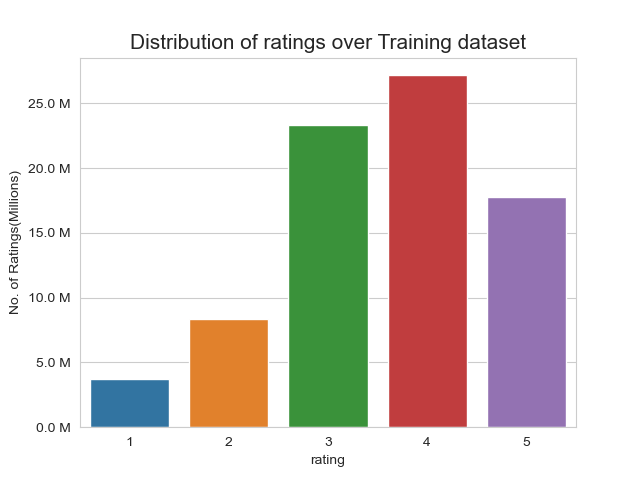

In [34]:
fig, ax = plt.subplots()
plt.title('Distribution of ratings over Training dataset', fontsize=15)
sns.countplot(train_df.rating)
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
ax.set_ylabel('No. of Ratings(Millions)')

plt.show()

#### Add new column (day_of_week) to the data set for analysis

In [39]:
# It is used to skip the warning ''SettingWithCopyWarning''.. 
pd.options.mode.chained_assignment = None  # default='warn'

train_df['day_of_week'] = train_df['date'].dt.day_name()

train_df.tail()

,movie,user,rating,date,day_of_week
80384400,12074,2033618,4,2005-08-08,Monday
80384401,862,1797061,3,2005-08-08,Monday
80384402,10986,1498715,5,2005-08-08,Monday
80384403,14861,500016,4,2005-08-08,Monday
80384404,5926,1044015,5,2005-08-08,Monday


## Number of Ratings per a month

<IPython.core.display.Javascript object>


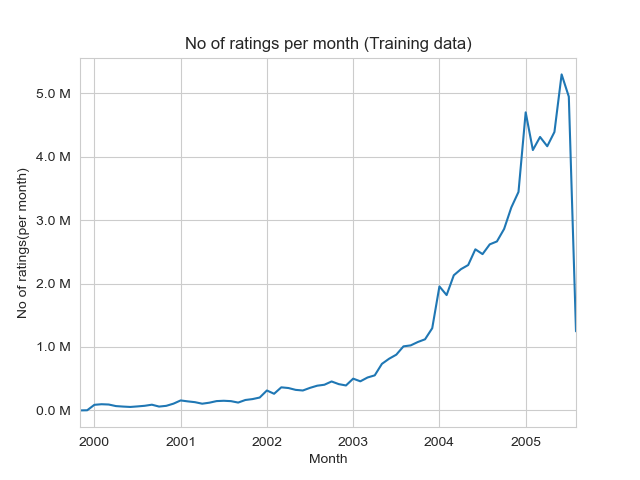

In [40]:
ax = train_df.resample('m', on='date')['rating'].count().plot()
ax.set_title('No of ratings per month (Training data)')
plt.xlabel('Month')
plt.ylabel('No of ratings(per month)')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

## Analysis on the Ratings given by user 

In [41]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()

user
305344     17112
2439493    15896
387418     15402
1639792     9767
1461435     9447
Name: rating, dtype: int64

<IPython.core.display.Javascript object>


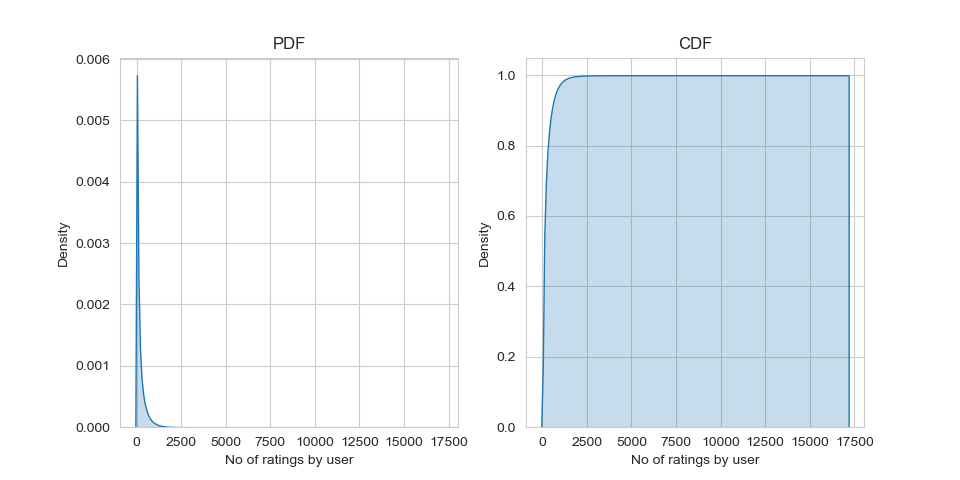

In [42]:
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [43]:
no_of_rated_movies_per_user.describe()

count    405041.000000
mean        198.459921
std         290.793238
min           1.000000
25%          34.000000
50%          89.000000
75%         245.000000
max       17112.000000
Name: rating, dtype: float64

In [44]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

<IPython.core.display.Javascript object>


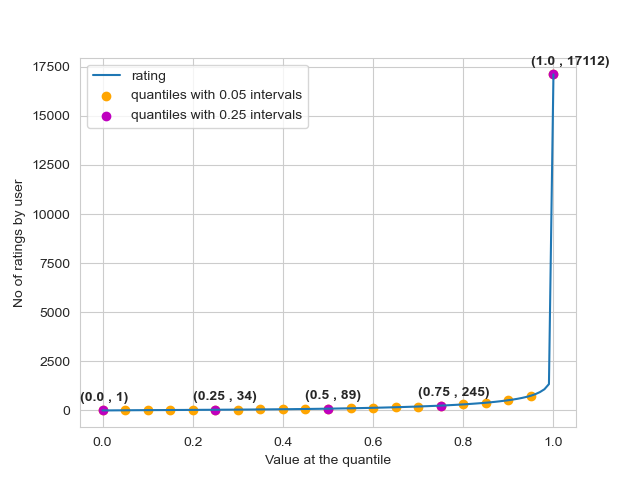

In [45]:
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# annotate the 25th, 50th, 75th and 100th percentile values....
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500)
                ,fontweight='bold')


plt.show()

In [46]:
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

- There are 5% of users who rated more than 749 movies.
- The 50th percentile or the median user has rated 89 movies.
- So 50% of users have rated more than 89 movies.
- 90% of users have rated more than 15 movies.


In [47]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )


 No of ratings at last 5 percentile : 20305



## Analysis of ratings of a movie given by a user

<IPython.core.display.Javascript object>


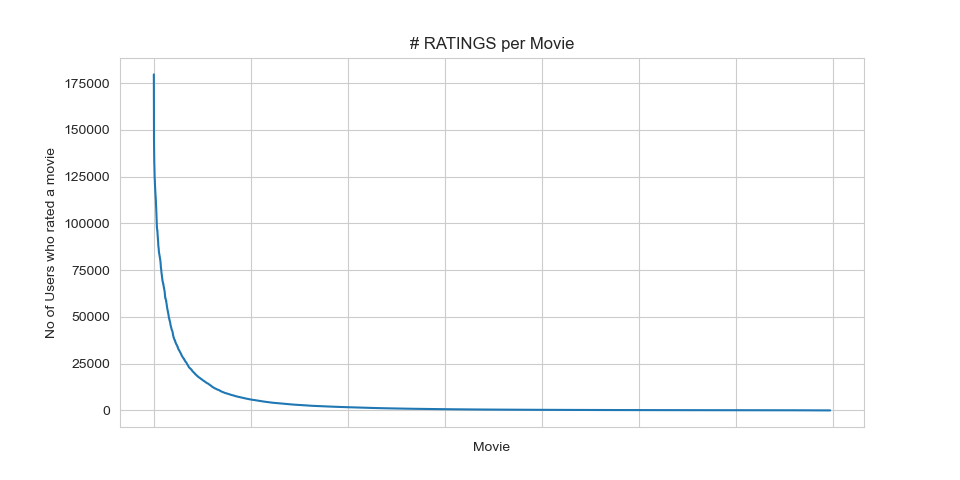

In [48]:
no_of_ratings_per_movie = train_df.groupby(by='movie')['rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_movie.values)
plt.title('# RATINGS per Movie')
plt.xlabel('Movie')
plt.ylabel('No of Users who rated a movie')
ax.set_xticklabels([])

plt.show()

- It is very skewed.
- There are some movies (which are very popular) which are rated by huge number of users.
- But most of the movies(like 90%) got some hundereds of ratings.

## Number of ratings on each day of the week

<IPython.core.display.Javascript object>


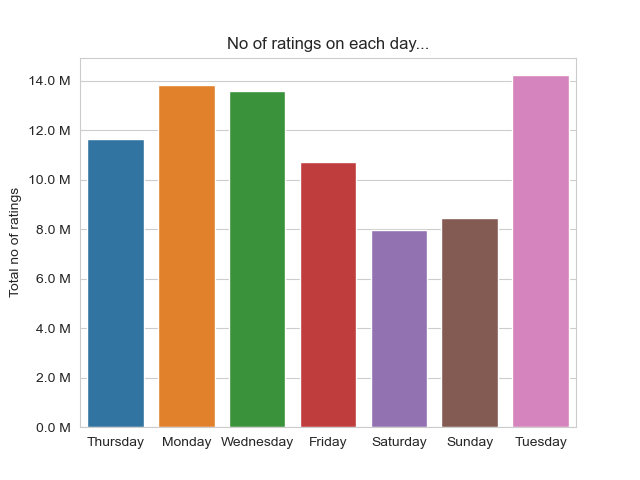

In [49]:
fig, ax = plt.subplots()
sns.countplot(x='day_of_week', data=train_df, ax=ax)
plt.title('No of ratings on each day...')
plt.ylabel('Total no of ratings')
plt.xlabel('')
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.show()

- No of ratings on sat and sun are far fewer than rest of the days because people in USA goes on mostly hiking and picnics.
- No of ratings on Tue is high and followed by monday and wednesday.


<IPython.core.display.Javascript object>


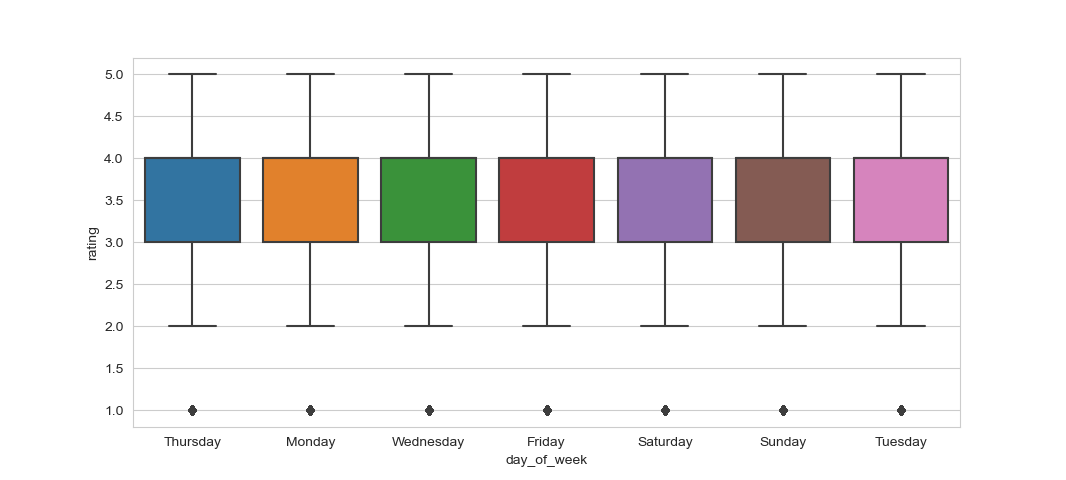

0:00:51.440143


In [50]:
start = datetime.now()
fig = plt.figure(figsize=plt.figaspect(.45))
sns.boxplot(y='rating', x='day_of_week', data=train_df)
plt.show()
print(datetime.now() - start)

- All the days are equally alligned, so day of the week is not an interesting feature to predict the rating.

In [51]:
avg_week_df = train_df.groupby(by=['day_of_week'])['rating'].mean()
print(" AVerage ratings")
print("-"*30)
print(avg_week_df)
print("\n")

 AVerage ratings
------------------------------
day_of_week
Friday       3.585274
Monday       3.577250
Saturday     3.591791
Sunday       3.594144
Thursday     3.582463
Tuesday      3.574438
Wednesday    3.583751
Name: rating, dtype: float64




- So to be more sure that day of the week cannot be a feature I found the average rating for every day. It is nearly same for every day. So it can’t be a feature. So we drop using this field called “ day of week”.


## Creating sparse matrix from data frame 

#### Creating sparse matrix from train data frame 

In [52]:
start = datetime.now()
if os.path.isfile(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\train_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    train_sparse_matrix = sparse.load_npz(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\train_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    train_sparse_matrix = sparse.csr_matrix((train_df.rating.values, (train_df.user.values,
                                               train_df.movie.values)),)
    
    print('Done. It\'s shape is : (user, movie) : ',train_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\train_sparse_matrix.npz", train_sparse_matrix)
    print('Done..\n')

print(datetime.now() - start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:00:50.019526


#### The Sparsity of Train Sparse Matrix

In [53]:
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Train matrix : 99.8292709259195 % 


#### Creating sparse matrix from test data frame 

In [54]:
start = datetime.now()
if os.path.isfile(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\test_sparse_matrix.npz'):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    test_sparse_matrix = sparse.load_npz(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\test_sparse_matrix.npz')
    print("DONE..")
else: 
    print("We are creating sparse_matrix from the dataframe..")
    # create sparse_matrix and store it for after usage.
    # csr_matrix(data_values, (row_index, col_index), shape_of_matrix)
    # It should be in such a way that, MATRIX[row, col] = data
    test_sparse_matrix = sparse.csr_matrix((test_df.rating.values, (test_df.user.values,
                                               test_df.movie.values)))
    
    print('Done. It\'s shape is : (user, movie) : ',test_sparse_matrix.shape)
    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\test_sparse_matrix.npz", test_sparse_matrix)
    print('Done..\n')
    
print(datetime.now() - start)

We are creating sparse_matrix from the dataframe..
Done. It's shape is : (user, movie) :  (2649430, 17771)
Saving it into disk for furthur usage..
Done..

0:00:15.969245


#### The Sparsity of Test data Matrix

In [55]:
us,mv = test_sparse_matrix.shape
elem = test_sparse_matrix.count_nonzero()

print("Sparsity Of Test matrix : {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity Of Test matrix : 99.95731772988694 % 


##  Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [56]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):
    
    # average ratings of user/movie
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array 
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Only rated/non null cells are considered.
    is_rated = sparse_matrix!=0
    # no of ratings by each user OR for each movie.
    no_of_ratings = is_rated.sum(axis=ax).A1
    
    # max_user  and max_movie ids in sparse matrix 
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m) 
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

#### finding global average of all movie ratings

In [57]:
train_averages = dict()
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_averages['global'] = train_global_average
train_averages

{'global': 3.582890686321557}

#### finding average rating per movie

In [59]:
train_averages['movie'] =  get_average_ratings(train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15 :',train_averages['movie'][15])


 AVerage rating of movie 15 : 3.3038461538461537


#### finding average rating per user

In [60]:
train_averages['user'] = get_average_ratings(train_sparse_matrix, of_users=True)
print('\nAverage rating of user 10 :',train_averages['user'][10])


Average rating of user 10 : 3.3781094527363185


#### PDF's & CDF's of Avg.Ratings of Users & Movies (In Train Data)

C:\Users\sweta\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\sweta\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\sweta\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

<IPython.core.display.Javascript object>


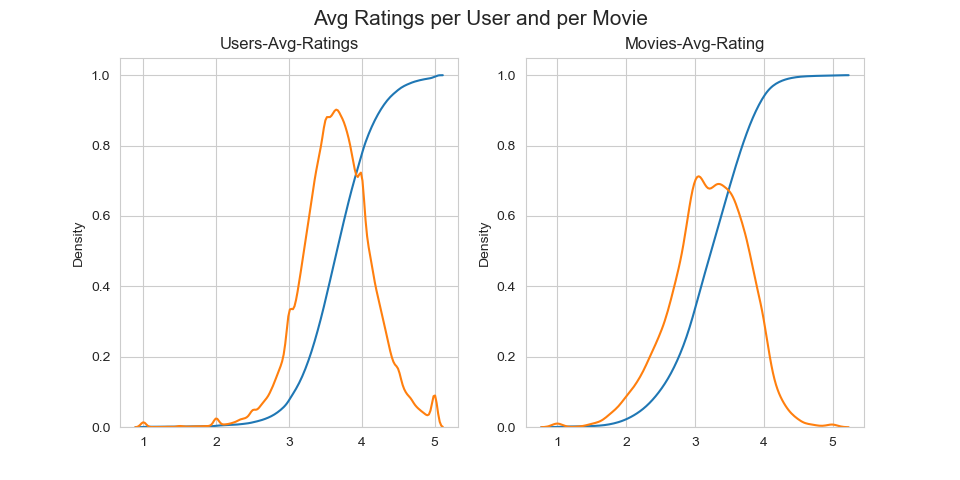

0:00:07.103154


In [61]:
start = datetime.now()
# draw pdfs for average rating per user and per movie
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

ax1.set_title('Users-Avg-Ratings')
# get the list of average user ratings from the averages dictionary..
user_averages = [rat for rat in train_averages['user'].values()]
sns.distplot(user_averages, ax=ax1, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=ax1, hist=False,label='Pdf')

ax2.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [rat for rat in train_averages['movie'].values()]
sns.distplot(movie_averages, ax=ax2, hist=False, 
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=ax2, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

## Cold Start problem

#### Cold Start problem with Users

In [62]:
total_users = len(np.unique(df.user))
users_train = len(train_averages['user'])
new_users = total_users - users_train

print('\nTotal number of Users  :', total_users)
print('\nNumber of Users in Train data :', users_train)
print("\nNo of Users that didn't appear in train data: {}({} %) \n ".format(new_users,
                                                                        np.round((new_users/total_users)*100, 2)))


Total number of Users  : 480189

Number of Users in Train data : 405041

No of Users that didn't appear in train data: 75148(15.65 %) 
 


#### Cold Start problem with Movies

In [65]:
total_movies = len(np.unique(df.movie))
movies_train = len(train_averages['movie'])
new_movies = total_movies - movies_train

print('\nTotal number of Movies  :', total_movies)
print('\nNumber of Users in Train data :', movies_train)
print("\nNo of Movies that didn't appear in train data: {}({} %) \n ".format(new_movies,
                                                                        np.round((new_movies/total_movies)*100, 2)))


Total number of Movies  : 17770

Number of Users in Train data : 17424

No of Movies that didn't appear in train data: 346(1.95 %) 
 


## Computing Similarity matrices 

#### Computing User-User Similarity matrix 


#### Trying with all dimensions (17k dimensions per user) 

In [68]:
row_index, col_index = train_sparse_matrix.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i)

6
7
10
25
33
42
59
79
83
87
94
97
131
134
142
149
158
168
169
178
183
188
189
192
195
199
201
242
247
248
261
265
266
267
268
283
291
296
298
299
301
302
304
305
307
308
310
312
314
330
331
333
352
363
368
369
379
383
384
385
392
413
416
424
437
439
440
442
453
462
470
471
477
478
479
481
485
490
491
492
495
508
515
517
527
529
536
540
544
546
550
561
576
585
592
596
602
609
614
616


In [69]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(61700).reshape(617,100)    # 617*100 = 61700. As we are building similarity matrix only 
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Time elapsed for 20 users = 0:02:23.214045sec
Time elapsed for 40 users = 0:04:39.082149sec
Time elapsed for 60 users = 0:06:51.684686sec
Time elapsed for 80 users = 0:09:06.841403sec
Time elapsed for 100 users = 0:11:18.703153sec
Average Time taken to compute similarity matrix for 1 user = 6.738267204761505seconds


<IPython.core.display.Javascript object>


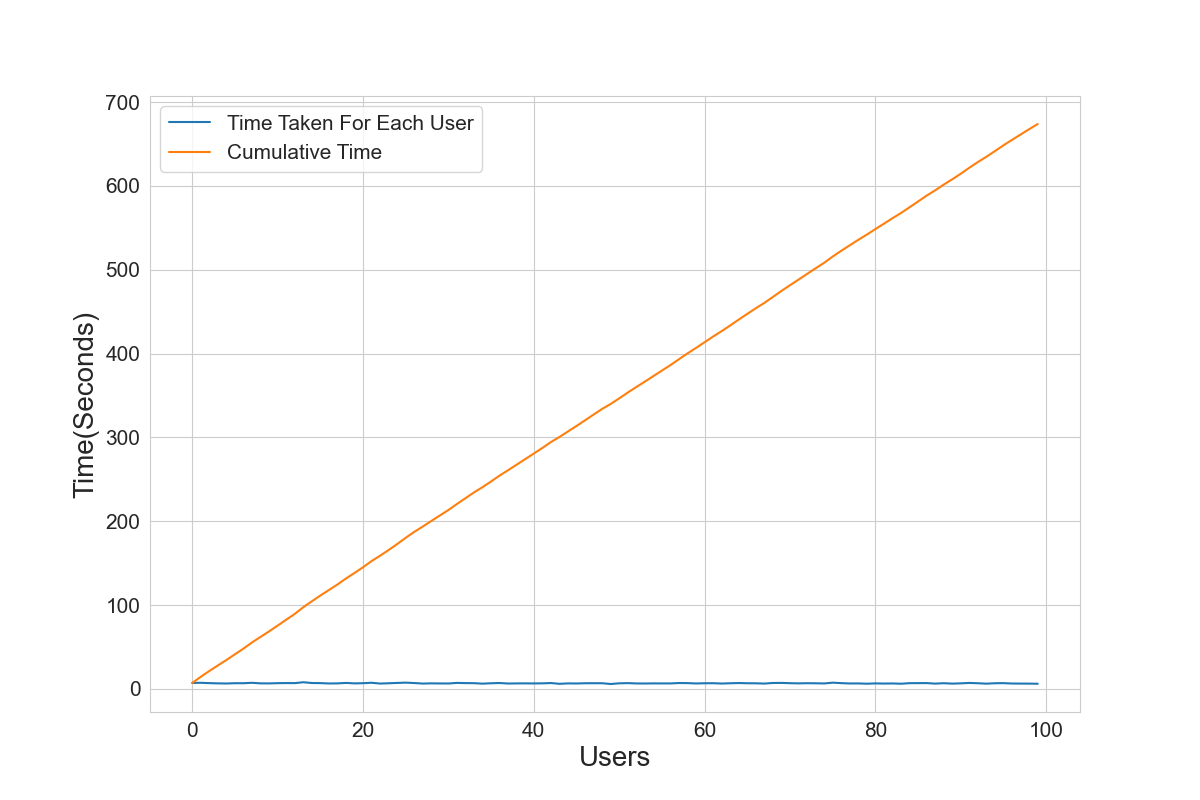

In [70]:
simMatrix = getUser_UserSimilarity(train_sparse_matrix, 100)

- We have 405041 Users in our training data.
- Average time taken to compute similarity matrix for one user is 6.738 sec.
- For 405041 users:
  405041*6.738 =  2729166.258sec = 758.10 hrs = 31 days
#### Computation of user-user similarity matrix is impossible if computational power is limited. On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of user-user similarity matrix would increase dramatically.

#### Is there any other way to compute user-user similarity???

- We maintain a binary Vector for users, which tells us whether we already computed similarity for this user or not.

#### OR

- We can compute top 1000 or top 2000 most similar most similar users for the given user and add it our data structure, so that we can just add it to our data structure which is dictionary of dictionary and can access it later.

Which datastructure to use:

It is purely implementation dependant.

One simple method is to maintain a Dictionary Of Dictionaries.


key : userid
value : Again a dictionary
key : _Similar User
value: Similarity Value>

#### Computing Movie-Movie Similarity Matrix

In [71]:
start = datetime.now()
if not os.path.isfile(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\m_m_sim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_matrix.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it for future purpose.
    print("Saving it to disk so that you don't need to re-compute it again.. ")
    sparse.save_npz(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\m_m_sim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity...
Done..
Saving it to disk so that you don't need to re-compute it again.. 
Done..
It's a  (17771, 17771)  dimensional matrix
0:15:28.259512


- Even though we have similarity measure of each movie, with all other movies, We generally don't care much about least similar movies.
- Most of the times, only top_xxx similar items matters. It may be 10 or 100.
- We take only those top similar movie ratings and store them in a saperate dictionary.

#### Does Movie-Movie Similarity Works?

#### Let's pick random movie and check it's top 10 most similar movies.

In [74]:
movie_titles = pd.read_csv(r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\movie_titles.csv", sep=',', header = None,
                           names=['movie_id', 'year_of_release', 'title'], verbose=True,
                      index_col = 'movie_id', encoding = "ISO-8859-1")

movie_titles.head()

Tokenization took: 3.99 ms
Type conversion took: 10.71 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


#### Similar Movies for 'Vampire Journals'

In [149]:
mv_id = 17765

print("\nMovie ----->",movie_titles.loc[mv_id].values[1])

print("\nIt has {} Ratings from users.".format(train_sparse_matrix[:,mv_id].getnnz()))

print("\nWe have {} movies which are similarto this  and we will get only top most..".format(m_m_sim_sparse[:,mv_id].getnnz()))


Movie -----> Godzilla's Revenge

It has 285 Ratings from users.

We have 17305 movies which are similarto this  and we will get only top most..


In [150]:
similarities = m_m_sim_sparse[mv_id].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]

similarities[similar_indices]

sim_indices = similarities.argsort()[::-1][1:] # It will sort and reverse the array and ignore its similarity (ie.,1)
                                               # and return its indices(movie_ids)

<IPython.core.display.Javascript object>


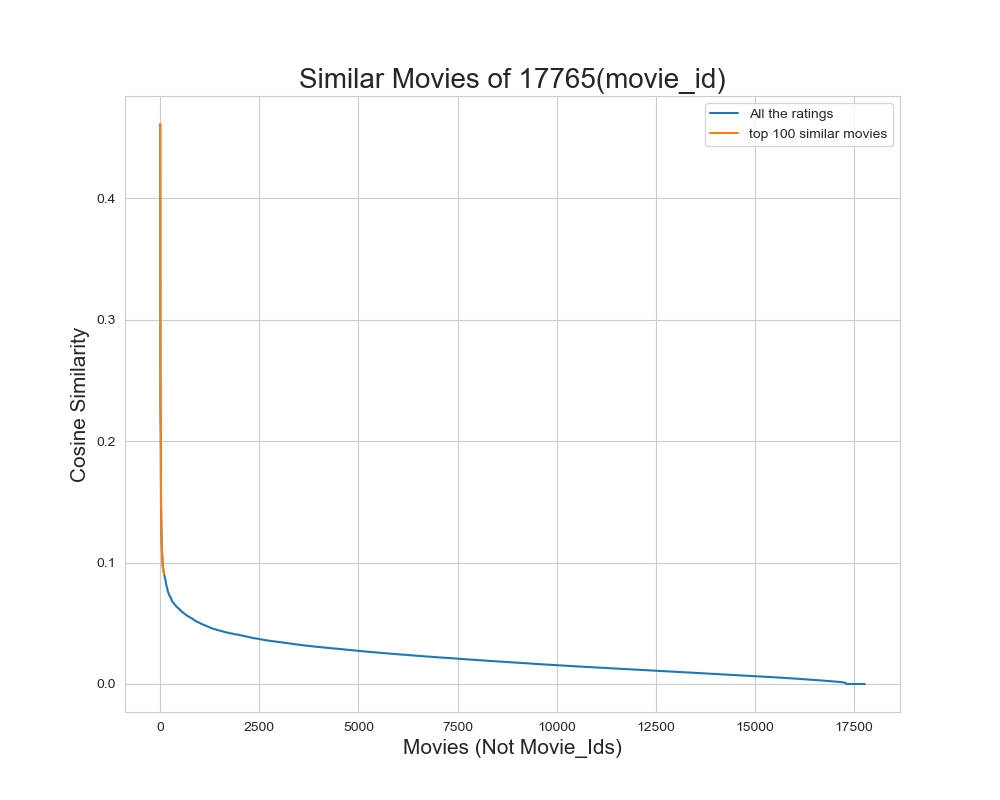

In [152]:
plt.figure(figsize = (10, 8))
plt.plot(similarities[sim_indices], label='All the ratings')
plt.plot(similarities[sim_indices[:100]], label='top 100 similar movies')
plt.title("Similar Movies of {}(movie_id)".format(mv_id), fontsize=20)
plt.xlabel("Movies (Not Movie_Ids)", fontsize=15)
plt.ylabel("Cosine Similarity",fontsize=15)
plt.legend()
plt.show()

#### Top 10 similar movies

In [153]:
movie_titles.loc[sim_indices[:10]]

,year_of_release,title
movie_id,,
15810,1964.0,Godzilla vs. Mothra
12252,1975.0,Terror of Mechagodzilla
5907,1956.0,Godzilla: King of the Monsters
14623,1971.0,Godzilla vs. Hedorah
409,1966.0,Godzilla vs. The Sea Monster
8233,1968.0,Destroy All Monsters
2459,1967.0,Son of Godzilla
10181,1999.0,Godzilla And Other Movie Monsters
10064,2004.0,Godzilla: The Series: Monster Wars Trilogy


- So we can observe that, movie similarity is working perfectly.
- Similarly, we can find similar users and compare how similar they are.

## Sampling data

- Due to low computational resources, I will be carrying out the further process on sample data of train and test.

In [157]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create 
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # This is just to make sure to get same sample everytime we run this program and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )
    
    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')
    
    return sample_sparse_matrix

#### Build sample train data from the train data

In [158]:
start = datetime.now()
path = r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else: 
    # get 10k users and 1k movies from available data 
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_matrix, no_users=10000, no_movies=1000,
                                             path = path)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 129286
Saving it into disk for furthur usage..
Done..

0:00:47.938067


#### Build sample test data from the test data

In [160]:
start = datetime.now()

path = r"C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data 
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_matrix, no_users=5000, no_movies=500,
                                                 path = path)
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..

0:00:09.893477


## Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [161]:
sample_train_averages = dict()

### Finding Global Average of all movie ratingsFinding Global Average of all movie ratings

In [162]:
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages

{'global': 3.581679377504138}

#### Finding Average rating per User

In [163]:
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])


Average rating of user 1515220 : 3.9655172413793105


#### Finding Average rating per Movie

In [164]:
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])


 AVerage rating of movie 15153 : 2.6458333333333335


## Featurizing data 

In [165]:
print('\n No of ratings in Our Sampled train matrix is : {}\n'.format(sample_train_sparse_matrix.count_nonzero()))
print('\n No of ratings in Our Sampled test  matrix is : {}\n'.format(sample_test_sparse_matrix.count_nonzero()))


 No of ratings in Our Sampled train matrix is : 129286


 No of ratings in Our Sampled test  matrix is : 7333



#### Featurizing train data for regression problem 

In [166]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)

In [167]:
start = datetime.now()
if os.path.isfile(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)    
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"        
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")    


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

File already exists you don't have to prepare again...
0:00:00.000882


#### Reading from the file to make a Train_dataframe

In [168]:
reg_train = pd.read_csv(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\reg_train.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating'], header=None)
reg_train.head()

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3
2,99865,33,3.581679,5.0,5.0,4.0,5.0,3.0,5.0,4.0,4.0,5.0,4.0,3.714286,4.092437,5
3,101620,33,3.581679,2.0,3.0,5.0,5.0,4.0,4.0,3.0,3.0,4.0,5.0,3.584416,4.092437,5
4,112974,33,3.581679,5.0,5.0,5.0,5.0,5.0,3.0,5.0,5.0,5.0,3.0,3.750000,4.092437,5


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 similar users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 similar movies rated by this movie.. )


- __UAvg__ : User's Average rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

#### Featurizing test data

In [169]:
# get users, movies and ratings from the Sampled Test 
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(sample_test_sparse_matrix)

In [170]:
sample_train_averages['global']

3.581679377504138

In [171]:
start = datetime.now()

if os.path.isfile(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\reg_test.csv'):
    print("It is already created...")
else:

    print('preparing {} tuples for the dataset..\n'.format(len(sample_test_ratings)))
    with open(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\reg_test.csv', mode='w') as reg_data_file:
        count = 0 
        for (user, movie, rating)  in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            st = datetime.now()

        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            #print(user, movie)
            try:
                # compute the similar Users of the "user"        
                user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
                top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar users for this movie
                top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
                # we will make it's length "5" by adding movie averages to .
                top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
                # print(top_sim_users_ratings, end="--")

            except (IndexError, KeyError):
                # It is a new User or new Movie or there are no ratings for given user for top similar movies...
                ########## Cold STart Problem ##########
                top_sim_users_ratings.extend([sample_train_averages['global']]*(5 - len(top_sim_users_ratings)))
                #print(top_sim_users_ratings)
            except:
                print(user, movie)
                # we just want KeyErrors to be resolved. Not every Exception...
                raise



            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            try:
                # compute the similar movies of the "movie"        
                movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
                top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
                # get the ratings of most similar movie rated by this user..
                top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
                # we will make it's length "5" by adding user averages to.
                top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
                top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings))) 
                #print(top_sim_movies_ratings)
            except (IndexError, KeyError):
                #print(top_sim_movies_ratings, end=" : -- ")
                top_sim_movies_ratings.extend([sample_train_averages['global']]*(5-len(top_sim_movies_ratings)))
                #print(top_sim_movies_ratings)
            except :
                raise

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            # add usser and movie name first
            row.append(user)
            row.append(movie)
            row.append(sample_train_averages['global']) # first feature
            #print(row)
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            #print(row)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            #print(row)
            # Avg_user rating
            try:
                row.append(sample_train_averages['user'][user])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # Avg_movie rating
            try:
                row.append(sample_train_averages['movie'][movie])
            except KeyError:
                row.append(sample_train_averages['global'])
            except:
                raise
            #print(row)
            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            #print(row)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            #print(','.join(map(str, row)))
            reg_data_file.write('\n')        
            if (count)%1000 == 0:
                #print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))
    print("",datetime.now() - start)  

It is already created...


In [172]:
reg_test_df = pd.read_csv(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\reg_test.csv', names = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                                                          'smr1', 'smr2', 'smr3', 'smr4', 'smr5',
                                                          'UAvg', 'MAvg', 'rating'], header=None)
reg_test_df.head(4)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4
2,1737912,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3
3,1849204,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4


-----------------------

- __GAvg__ : Average rating of all the ratings 


- __Similar users rating of this movie__:
    - sur1, sur2, sur3, sur4, sur5 ( top 5 simiular users who rated that movie.. )
    


- __Similar movies rated by this user__:
    - smr1, smr2, smr3, smr4, smr5 ( top 5 simiular movies rated by this movie.. )


- __UAvg__ : User AVerage rating


- __MAvg__ : Average rating of this movie


- __rating__ : Rating of this movie by this user.

-----------------------

## Transforming data for Surprise models

In [173]:
from surprise import Reader, Dataset

#### Transforming train data 

- We can't give raw data (movie, user, rating) to train the model in Surprise library.
- They have a saperate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.
- We can form the trainset from a file, or from a Pandas DataFrame.http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py

In [174]:
reader = Reader(rating_scale=(1,5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(reg_train[['user', 'movie', 'rating']], reader)

# build the trainset from traindata. It is of dataset format from surprise library.
trainset = train_data.build_full_trainset() 

#### Transforming test data

- Testset is just a list of (user, movie, rating) tuples. (Order in the tuple is impotant)

In [175]:
testset = list(zip(reg_test_df.user.values, reg_test_df.movie.values, reg_test_df.rating.values))
testset[:3]

[(808635, 71, 5), (941866, 71, 4), (1737912, 71, 3)]

## Applying Machine Learning models

-  Global dictionary that stores rmse and mape for all the models....

    - It stores the metrics in a dictionary of dictionaries

    > __keys__ : model names(string)

    > __value__: dict(__key__ : metric, __value__ : value ) 

In [176]:
models_evaluation_train = dict()
models_evaluation_test = dict()

models_evaluation_train, models_evaluation_test

({}, {})

> #### Utility functions for running regression models

In [177]:
# to get rmse and mape given actual and predicted ratings.
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean([ (y_true[i] - y_pred[i])**2 for i in range(len(y_pred)) ]))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape


###################################################################


def run_xgboost(algo,  x_train, y_train, x_test, y_test, verbose=True):
    """
    It will return train_results and test_results
    """
    
    # dictionaries for storing train and test results
    train_results = dict()
    test_results = dict()
    
    
    # fit the model
    print('Training the model..')
    start =datetime.now()
    algo.fit(x_train, y_train, eval_metric = 'rmse')
    print('Done. Time taken : {}\n'.format(datetime.now()-start))
    print('Done \n')

    # from the trained model, get the predictions....
    print('Evaluating the model with TRAIN data...')
    start =datetime.now()
    y_train_pred = algo.predict(x_train)
    # get the rmse and mape of train data...
    rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
    
    # store the results in train_results dictionary..
    train_results = {'rmse': rmse_train,
                    'mape' : mape_train,
                    'predictions' : y_train_pred}
    
    #######################################
    # get the test data predictions and compute rmse and mape
    print('Evaluating Test data')
    y_test_pred = algo.predict(x_test) 
    rmse_test, mape_test = get_error_metrics(y_true=y_test.values, y_pred=y_test_pred)
    # store them in our test results dictionary.
    test_results = {'rmse': rmse_test,
                    'mape' : mape_test,
                    'predictions':y_test_pred}
    if verbose:
        print('\nTEST DATA')
        print('-'*30)
        print('RMSE : ', rmse_test)
        print('MAPE : ', mape_test)
        
    # return these train and test results...
    return train_results, test_results

> #### Utility functions for Surprise modes

In [178]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...

my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

# Get the actual list and predicted list of ratings.
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred


In [179]:
# get ''rmse'' and ''mape'' , given list of prediction objecs 
def get_errors(predictions, print_them=False):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

In [180]:
##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, verbose=True): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    start = datetime.now()
    # dictionaries that stores metrics for train and test..
    train = dict()
    test = dict()
    
    # train the algorithm with the trainset
    st = datetime.now()
    print('Training the model...')
    algo.fit(trainset)
    print('Done. time taken : {} \n'.format(datetime.now()-st))
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    print('Evaluating the model with train data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Train Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(train_rmse, train_mape))
    
    #store them in the train dictionary
    if verbose:
        print('adding train results in the dictionary..')
    train['rmse'] = train_rmse
    train['mape'] = train_mape
    train['predictions'] = train_pred_ratings
    
    #------------ Evaluating Test data---------------#
    st = datetime.now()
    print('\nEvaluating for test data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    print('time taken : {}'.format(datetime.now()-st))
    
    if verbose:
        print('-'*15)
        print('Test Data')
        print('-'*15)
        print("RMSE : {}\n\nMAPE : {}\n".format(test_rmse, test_mape))
    # store them in test dictionary
    if verbose:
        print('storing the test results in test dictionary...')
    test['rmse'] = test_rmse
    test['mape'] = test_mape
    test['predictions'] = test_pred_ratings
    
    print('\n'+'-'*45)
    print('Total time taken to run this algorithm :', datetime.now() - start)
    
    # return two dictionaries train and test
    return train, test

## 1. XGBoost with initial 13 features

#### The first model, we will train is Regression XGBoost model with initial 13 handcrafted features.

In [181]:
import xgboost as xgb

Training the model..
[16:48:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Done. Time taken : 0:00:05.730537

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1016770831525975
MAPE :  33.379025364595144


<IPython.core.display.Javascript object>


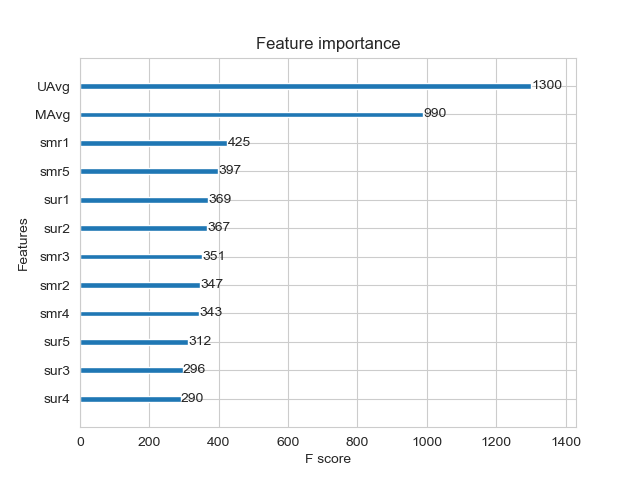

In [182]:
# prepare Train data
x_train = reg_train.drop(['user','movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
first_xgb = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(first_xgb, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['first_algo'] = train_results
models_evaluation_test['first_algo'] = test_results

xgb.plot_importance(first_xgb)
plt.show()

### Observations:
- I have used here XGBoost Regressor.
- I got about 1.1 as my test RMSE (root mean square error) and 33% as my test MAPE.
- Remember we have trained our model on a very small dataset due to  COMPUTATIONAL RESOURCES problem. If we train this model on the complete dataset, then we will surely get significantly much bettter results/ absolutely much lower errors.
- The most important plot is the feature importance plot. So the most important feature is user average and followed by movie average.
- The importance of user average is 1300, while importance of movie average is 990, which creates quiate a difference and states how important user average as a feature is.
- The user avaerage states that if a user is a critical user or not., which is followed by movie average which states that if a movie is super hit or popular ot not.


## 2. Suprise BaselineModel 

In [183]:
from surprise import BaselineOnly 

__Predicted_rating : ( baseline prediction ) __

    -  http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly 
 >$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $


- $\pmb \mu $ : Average of all trainings in training data.
- $\pmb b_u$ : User bias
- $\pmb b_i$ : Item bias (movie biases) 

__Optimization function ( Least Squares Problem ) __

    - http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration 

> $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right).\text {        [mimimize } {b_u, b_i]}$ 

In [184]:
bsl_options = {'method': 'sgd',
               'learning_rate': .001
               }
bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results = run_surprise(bsl_algo, trainset, testset, verbose=True)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results 
models_evaluation_test['bsl_algo'] = bsl_test_results

Training the model...
Estimating biases using sgd...
Done. time taken : 0:00:00.949678 

Evaluating the model with train data..
time taken : 0:00:00.886593
---------------
Train Data
---------------
RMSE : 0.9347153928678286

MAPE : 29.389572652358183

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.052758
---------------
Test Data
---------------
RMSE : 1.0730330260516174

MAPE : 35.04995544572911

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:01.889454


#### Observation
- The RMSE is slightly better than XGBoost with initial 13 features.

## 3. XGBoost with initial 13 features + Surprise Baseline predictor 

Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

#### Updating Train Data

In [185]:
# add our baseline_predicted value as our feature..
reg_train['bslpr'] = models_evaluation_train['bsl_algo']['predictions']
reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403


In [186]:
# add that baseline predicted ratings with Surprise to the test data as well
reg_test_df['bslpr']  = models_evaluation_test['bsl_algo']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679


Training the model..
[17:39:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Done. Time taken : 0:00:09.767011

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1000463052939882
MAPE :  33.440093738533456


<IPython.core.display.Javascript object>


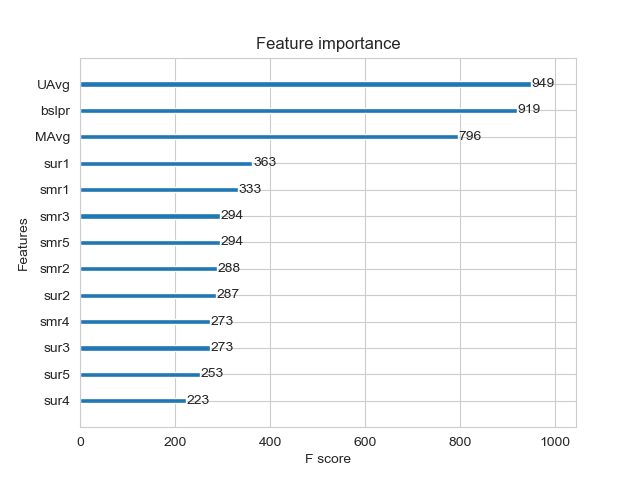

In [188]:
# prepare train data
x_train = reg_train.drop(['user', 'movie','rating'], axis=1)
y_train = reg_train['rating']

# Prepare Test data
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# initialize Our first XGBoost model...
xgb_bsl = xgb.XGBRegressor(silent=False, n_jobs=13, random_state=15, n_estimators=100)
train_results, test_results = run_xgboost(xgb_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_bsl'] = train_results
models_evaluation_test['xgb_bsl'] = test_results

xgb.plot_importance(xgb_bsl)
plt.show()


#### Observations:
- Baseline predictor is one of the most important feature after user average.
- Here F-score basically means feature score.

## 4. Surprise KNNBaseline predictor

In [189]:
from surprise import KNNBaseline

- KNN BASELINE
    - http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline 

- PEARSON_BASELINE SIMILARITY
    - http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline 

- SHRINKAGE
    - _2.2 Neighborhood Models_ in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf 

- __predicted Rating__ : ( ___ based on User-User similarity ___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  _Baseline prediction_ of (user,movie) rating

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
       

- __ Predicted rating __ ( based on Item Item similarity ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

    -  ___Notations follows same as above (user user based predicted rating ) ___

#### Surprise KNNBaseline with user user similarities

In [192]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_u = KNNBaseline(k=60, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results = run_surprise(knn_bsl_u, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_u'] = knn_bsl_u_train_results 
models_evaluation_test['knn_bsl_u'] = knn_bsl_u_test_results


Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:34.496961 

Evaluating the model with train data..
time taken : 0:01:44.985250
---------------
Train Data
---------------
RMSE : 0.41440848072113173

MAPE : 11.51009467726276

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.061741
---------------
Test Data
---------------
RMSE : 1.072644016220397

MAPE : 35.02049141836246

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:19.544467


#### Surprise KNNBaseline with movie movie similarities

In [195]:
sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 2
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options)

knn_bsl_m_train_results, knn_bsl_m_test_results = run_surprise(knn_bsl_m, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_test['knn_bsl_m'] = knn_bsl_m_test_results

Training the model...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Done. time taken : 0:00:01.521403 

Evaluating the model with train data..
time taken : 0:00:10.253016
---------------
Train Data
---------------
RMSE : 0.32584796251610554

MAPE : 8.447062581998374

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.073125
---------------
Test Data
---------------
RMSE : 1.072758832653683

MAPE : 35.02269653015042

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:11.848057


## 5. XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor

#### preparing training data

In [196]:
# add the predicted values from both knns to this dataframe
reg_train['knn_bsl_u'] = models_evaluation_train['knn_bsl_u']['predictions']
reg_train['knn_bsl_m'] = models_evaluation_train['knn_bsl_m']['predictions']

reg_train.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,5.0,3.0,1.0,3.370370,4.092437,4,3.898982,3.913940,3.867958
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,4.0,3.0,5.0,3.555556,4.092437,3,3.371403,3.222364,3.076302


#### preparing test data

In [197]:
reg_test_df['knn_bsl_u'] = models_evaluation_test['knn_bsl_u']['predictions']
reg_test_df['knn_bsl_m'] = models_evaluation_test['knn_bsl_m']['predictions']

reg_test_df.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679


Training the model..
Done. Time taken : 0:00:13.602333

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.1575128708332205
MAPE :  32.11580281572139


<IPython.core.display.Javascript object>


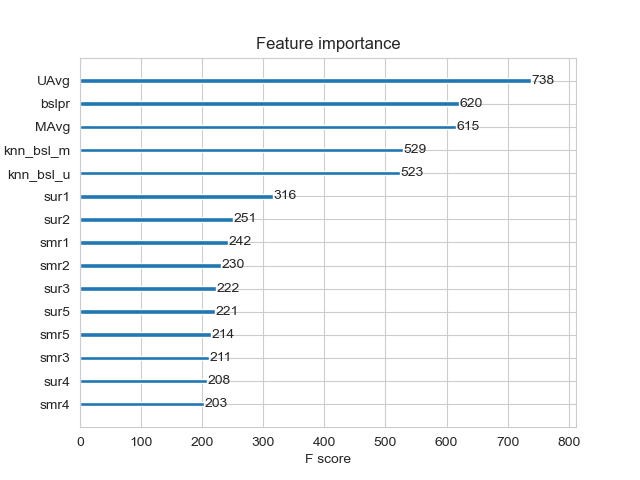

In [198]:
# prepare the train data....
x_train = reg_train.drop(['user', 'movie', 'rating'], axis=1)
y_train = reg_train['rating']

# prepare the train data....
x_test = reg_test_df.drop(['user','movie','rating'], axis=1)
y_test = reg_test_df['rating']

# declare the model
xgb_knn_bsl = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_knn_bsl, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_knn_bsl'] = train_results
models_evaluation_test['xgb_knn_bsl'] = test_results


xgb.plot_importance(xgb_knn_bsl)
plt.show()

## 6. Matrix Factorization Techniques

#### SVD Matrix Factorization User Movie intractions (explicit feedback)

In [199]:
from surprise import SVD

-  Predicted Rating : 
    - 
    - $ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
        


- __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - 
    - $\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $

In [200]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, verbose=True)
svd_train_results, svd_test_results = run_surprise(svd, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results

Training the model...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Done. time taken : 0:00:07.621225 

Evaluating the model with train data..
time taken : 0:00:01.315490
---------------
Train Data
---------------
RMSE : 0.6574721240954099

MAPE : 19.704901088660478

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.187496
---------------
Test Data
---------------
RMSE : 1.0726046873826458

MAPE : 35.01953535988152

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:00:09.124211


#### SVD Matrix Factorization with implicit feedback from user ( user rated movies )

In [201]:
from surprise import SVDpp

-  Predicted Rating : 
    - 
    - $ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $ 

 - $ \pmb{I_u}$ --- the set of all items rated by user u

- $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings. 

- Optimization problem with user item interactions and regularization (to avoid overfitting)
    - 
    - $ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ 

In [202]:
# initiallize the model
svdpp = SVDpp(n_factors=50, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results = run_surprise(svdpp, trainset, testset, verbose=True)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results 
models_evaluation_test['svdpp'] = svdpp_test_results


Training the model...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
Done. time taken : 0:02:23.261758 

Evaluating the model with train data..
time taken : 0:00:06.686230
---------------
Train Data
---------------
RMSE : 0.6032438403305899

MAPE : 17.49285063490268

adding train results in the dictionary..

Evaluating for test data...
time taken : 0:00:00.076071
---------------
Test Data
---------------
RMSE : 1.0728491944183447

MAPE : 35.03817913919887

storing the test results in test dictionary...

---------------------------------------------
Total time taken to run this algorithm : 0:02:30.027112


## 7. XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques

#### preparing Train data

In [203]:
# add the predicted values from svd and svd++ to this dataframe
reg_train['svd'] = models_evaluation_train['svd']['predictions']
reg_train['svdpp'] = models_evaluation_train['svdpp']['predictions']

reg_train.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,53406,33,3.581679,4.0,5.0,5.0,4.0,1.0,5.0,2.0,...,3.0,1.0,3.370370,4.092437,4,3.898982,3.913940,3.867958,4.303764,3.621664
1,99540,33,3.581679,5.0,5.0,5.0,4.0,5.0,3.0,4.0,...,3.0,5.0,3.555556,4.092437,3,3.371403,3.222364,3.076302,3.278967,3.538247


#### preparing Test data

In [204]:
reg_test_df['svd'] = models_evaluation_test['svd']['predictions']
reg_test_df['svdpp'] = models_evaluation_test['svdpp']['predictions']

reg_test_df.head(2) 

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bslpr,knn_bsl_u,knn_bsl_m,svd,svdpp
0,808635,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,5,3.581679,3.581679,3.581679,3.581679,3.581679
1,941866,71,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,3.581679,...,3.581679,3.581679,3.581679,3.581679,4,3.581679,3.581679,3.581679,3.581679,3.581679


Training the model..
Done. Time taken : 0:00:08.239998

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0814423216821691
MAPE :  34.22029029705821


<IPython.core.display.Javascript object>


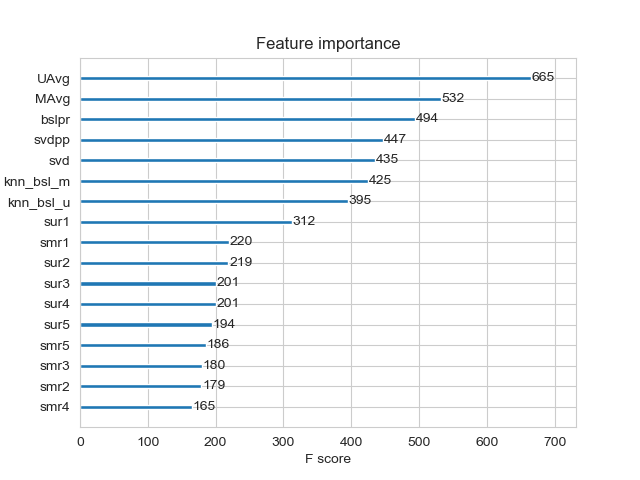

In [205]:
# prepare x_train and y_train
x_train = reg_train.drop(['user', 'movie', 'rating',], axis=1)
y_train = reg_train['rating']

# prepare test data
x_test = reg_test_df.drop(['user', 'movie', 'rating'], axis=1)
y_test = reg_test_df['rating']



xgb_final = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_final, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_final'] = train_results
models_evaluation_test['xgb_final'] = test_results


xgb.plot_importance(xgb_final)
plt.show()

## 8. XGBoost with Surprise KNN models + (MF)Matrix Factorization Techniques

Training the model..
Done. Time taken : 0:00:06.268239

Done 

Evaluating the model with TRAIN data...
Evaluating Test data

TEST DATA
------------------------------
RMSE :  1.0858464473392273
MAPE :  34.17920125571754


<IPython.core.display.Javascript object>


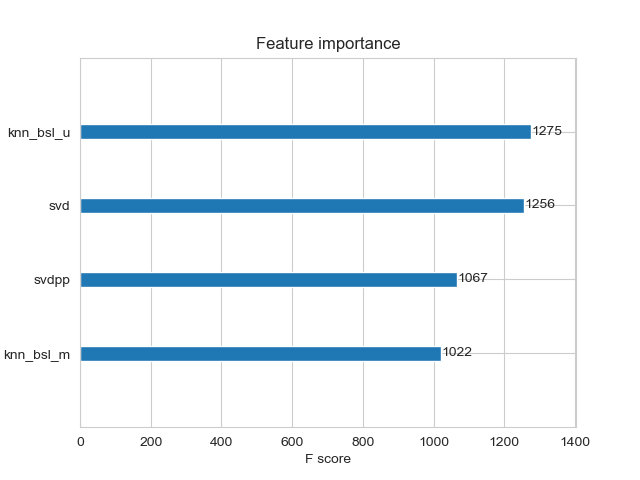

In [206]:
# prepare train data
x_train = reg_train[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_train = reg_train['rating']

# test data
x_test = reg_test_df[['knn_bsl_u', 'knn_bsl_m', 'svd', 'svdpp']]
y_test = reg_test_df['rating']


xgb_all_models = xgb.XGBRegressor(n_jobs=10, random_state=15)
train_results, test_results = run_xgboost(xgb_all_models, x_train, y_train, x_test, y_test)

# store the results in models_evaluations dictionaries
models_evaluation_train['xgb_all_models'] = train_results
models_evaluation_test['xgb_all_models'] = test_results

xgb.plot_importance(xgb_all_models)
plt.show()

## Comparision between all models

In [207]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\small_sample_results.csv')
models = pd.read_csv(r'C:\Users\sweta\OneDrive\Desktop\Data mining projects\Netflix recommender system\small_sample_results.csv', index_col=0)
models.loc['rmse'].sort_values()

svd               1.0726046873826458
knn_bsl_u          1.072644016220397
knn_bsl_m          1.072758832653683
svdpp             1.0728491944183447
bsl_algo          1.0730330260516174
xgb_final         1.0814423216821691
xgb_all_models    1.0858464473392273
xgb_bsl           1.1000463052939882
first_algo        1.1016770831525975
xgb_knn_bsl       1.1575128708332205
Name: rmse, dtype: object

- Lower the RMSE, the better the model.
- SVD model performed the best.
- We can just carry out the hyperparameter tuning and lower the RMSE error and significantly improve the result.